In [2]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

warnings.filterwarnings("ignore")

In [23]:
def load(file_name, header=None) -> pd.DataFrame:
    """Loading dataset
    @param file_name: user input dataset
    @return: dataset
    """
    if os.path.exists(file_name) == False:
        raise ValueError("Entered File is not found")
    if os.path.isdir(file_name):
        raise ValueError("Entered string is a directory")
    if header == False:
        return pd.read_csv(file_name, header=None)
    return pd.read_csv(file_name)

def copy_df(df) -> pd.DataFrame:
    """copy df to new temp df
    @param df: user input dataset
    @return: new df
    """
    return df.copy(deep=True)

def normalize_missing_values(dataset) -> pd.DataFrame:
    """normalize dataset missing values with mean for numerical columns
    @param dataset: user input dataset
    @return: normalized dataset
    """
    for col in dataset.columns:
        # print("column: ",col, "type: ", dataset[col].dtype)
        if dataset[col].dtype == 'object':
            dataset[col] = dataset[col].fillna(method='bfill')
        else:
            dataset[col] = dataset[col].fillna(dataset[col].mean()) 
    return dataset

def print_dataset(dataset):
    """print dataset inforamtion
    @param dataset: user input dataset
    @return: print dataset information via head(), info(), shape()
    """
    print(dataset.head())
    print(dataset.info())
    print(dataset.describe())
    print(dataset.columns)
    print(dataset.iloc[:, -1].value_counts())

def dummy_encode_categorical_column(data, column_name) -> pd.DataFrame:
    """dummy variable indicator
    @param data: user input data
    @param column_name: column name
    @return: data with dummy variable indicator
    """
    if column_name not in data.columns:
        raise ValueError("Column not found")
    data = pd.get_dummies(data, columns=[column_name])
    return data

def remove_column(data, column_name) -> pd.DataFrame:
    """remove column
    @param data: user input data
    @param column_name: column name
    @return: data without column
    """
    if column_name not in data.columns:
        raise ValueError("Column not found")
    data = data.drop(column_name, axis=1)
    return data

def normalize_numerical_columns(data) -> pd.DataFrame:
    """normalize numerical columns to 0-1 scale
    @param data: user input data
    @return: normalized data
    """
    for col in data.columns:
        if data[col].dtype == 'float64':
            data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())
    return data


def concat_data(x_data, y_data) -> list:
    """
    @param x_data: feature data
    @param y_data: label data
    @return: concatenation of features and label data
    """
    return pd.concat([x_data, y_data], axis=1)

def train_test_split(x_data, y_data=None, train_size=None, test_size=None, random_state=None, shuffle=None) -> tuple:
    """split dataset into train, validation and test
    @param data: user input dataset
    @param train_size: user input train size
    @param test_size: user input test size
    @param random_state: user input random state
    @return: train, validation and test dataset
    """
    if train_size is None and test_size is None:
        raise ValueError("train_size and test_size can not be both None")
    if train_size is not None and test_size is not None and train_size + test_size > 1:
        raise ValueError("train_size and test_size sum must be equal to 1")
    if train_size is not None and test_size is not None and train_size + test_size < 1:
        raise ValueError("train_size and test_size sum is not equal to one")
    if train_size is not None:
        if train_size <= 0:
            raise ValueError("train_size must be greater than 0")
        if train_size >= 1:
            raise ValueError("train_size must be less than 1")
        if test_size is None:
            test_size = 1 - train_size
        elif test_size <= 0:
            raise ValueError("test_size must be greater than 0")
        elif test_size >= 1:
            raise ValueError("test_size must be less than 1")
    if test_size is not None:
        if test_size <= 0:
            raise ValueError("test_size must be greater than 0")
        if test_size >= 1:
            raise ValueError("test_size must be less than 1")
        if train_size is None:
            train_size = 1 - test_size
        elif train_size <= 0:
            raise ValueError("train_size must be greater than 0")
        elif train_size >= 1:
            raise ValueError("train_size must be less than 1")
    
    if y_data is not None:
        data = concat_data(x_data, y_data)    
    if y_data is None:
        data = x_data.copy(deep=True)

    train_size = int(len(data) * train_size)
    test_size = int(len(data) * test_size)
    if shuffle is True:
        data = data.sample(frac=1).reset_index(drop=True)
    
    # print("train_size: ", train_size, "test_size: ", test_size, 'sum: ', train_size + test_size)
    train_index = np.random.choice(len(data), train_size, replace=False)
    
    # split train data
    x_train = data.iloc[train_index, :-1].reset_index(drop=True)
    # x_train = data.drop(, axis=1).iloc[train_index].reset_index(drop=True)
    y_train = data.iloc[train_index, -1:].reset_index(drop=True)
    
    # differnetiate train indexes from whole data indexes
    test_index = np.setdiff1d(np.arange(len(data)), train_index)

    # split test data
    x_test = data.iloc[test_index, :-1].reset_index(drop=True)
    # x_test = data.drop('median_house_value', axis=1).iloc[test_index].reset_index(drop=True)
    y_test = data.iloc[test_index, -1:].reset_index(drop=True)
    return x_train, y_train, x_test, y_test

def reshape_to_1d(*arrays):
    """
    Reshape all arrays to 1D
    @param arrays: input arrays
    @return: reshaped arrays
    """
    return [np.reshape(array, (array.shape[0],)) for array in arrays]

def print_hypothesis(x_data, theta):
    """Print hypothesis
    @param x_data: x_data
    @param theta: wights
    """
    H_x = "H(x) = " + "{:.2f}".format(theta[0]) + " + "
    for index in range(1, x_data.shape[1]):
        if (index+1) != x_data.shape[1]:
            H_x += "{:.2f}".format(theta[index]) + f"*x_{index} + "
        else:
            H_x += "{:.2f}".format(theta[index]) + f"*x_{index}"
    print(H_x)

def hypothesis(x_data, theta_or_weight):
    """Hypothesis function
    @param x_data: train data
    @param theta_or_weight: parameter
    """
    return np.dot(x_data, theta_or_weight)

def loss_function_with_regularization(x_data, y_data, weights, regularization_parameter):
    """Loss Function with regularization
    @param x_data: train data
    @param y_data: train label
    @param theta: weights
    @param regularization_parameter: lambda regularization parameter
    @return: loss function value
    """
    m_number_of_samples = x_data.shape[0]
    j_theta_1_mse_loss = (1 / (2 * m_number_of_samples)) * np.sum(np.square(hypothesis(x_data, weights) - y_data))
    j_theta_2_regularization_loss = (regularization_parameter / (2 * m_number_of_samples)) * np.sum(np.square(weights))
    return j_theta_1_mse_loss + j_theta_2_regularization_loss

def loss_function(x_data, y_data, theta):
    """Loss Function without regularization
    @param x_data: train data
    @param y_data: train label
    @param theta: weights
    @return: loss function value
    """
    m_number_of_samples = x_data.shape[0]
    j_theta_1_mse_loss = np.sum(np.square(hypothesis(x_data, theta) - y_data)) / 2 * m_number_of_samples
    return j_theta_1_mse_loss

def gradient_descent(x_train, y_train, x_validation, y_validation, theta, alpha, regularization_parameter):
    """gradient_descent
    @param x_train: train data
    @param y_train: train label
    @param x_validation: validation data
    @param y_validation: validation label
    @param theta: wieghts
    @param alpha: learning rate
    @param regularization_paramet: lambda regularization parameter
    @return: updated wieghts and loss function value
    """

    penalty = 5
    iteration = 0
    theta_list = []
    train_cost_list = []
    validation_cost_list = []
    m_number_of_samples = x_train.shape[0]

    theta_list.append([*theta])
    train_cost_list.append(loss_function_with_regularization(x_train.copy(), y_train.copy(), theta, regularization_parameter))
    validation_cost_list.append(loss_function_with_regularization(x_validation.copy(), y_validation.copy(), theta, regularization_parameter))

    while True:
        iteration = iteration + 1
        if iteration % 5000 == 0:
            print("iteration: ", iteration, "alpha: ", alpha, "regularization_parameter: ", regularization_parameter, "Validation loss: ", validation_cost_list[-1], "Train loss: ", train_cost_list[-1])
        
        hypothesis_value = hypothesis(x_train, theta)
        # updating θ_j with regularization
        for j_index in range(theta.shape[0]):
            if j_index != 0:
                theta[j_index] -= alpha *  (1 / m_number_of_samples) * (np.dot(hypothesis_value - y_train, x_train[:, j_index]) + regularization_parameter * theta[j_index])
            else:
                theta[j_index] -= alpha *  (1 / m_number_of_samples) * np.dot(hypothesis_value - y_train, x_train[:, j_index])

        theta_list.append([*theta])
        train_cost_list.append(loss_function_with_regularization(x_train.copy(), y_train.copy(), theta, regularization_parameter))
        validation_cost_list.append(loss_function_with_regularization(x_validation.copy(), y_validation.copy(), theta, regularization_parameter))

        if len(validation_cost_list) >= 4:
            treshold_list = np.array(validation_cost_list[-4:])
            if treshold_list[-1 and -2 and -3] > treshold_list[-4]:
                    print("iteration: ", iteration, "alpha: ", alpha, "regularization_parameter: ", regularization_parameter, "Validation loss: ", validation_cost_list[-1], "Train loss: ", train_cost_list[-1])
                    return theta_list[-4], theta_list[:-3], train_cost_list, validation_cost_list

        if len(validation_cost_list) >= 3:
            plateau_list = np.array(validation_cost_list[-3:])
            if np.round(plateau_list[-1], 3) == np.round(plateau_list[-2], 3) == np.round(plateau_list[-3], 3):
                penalty = penalty - 1
                if penalty > 0:
                    continue
                else:
                    print("iteration: ", iteration, "alpha: ", alpha, "regularization_parameter: ", regularization_parameter, "Validation loss: ", validation_cost_list[-1], "Train loss: ", train_cost_list[-1])
                    return theta_list[-1], theta_list, train_cost_list, validation_cost_list

def fit_linear_regression(x_train, y_train, x_validation, y_validation, theta=None, alpha=.5, regularization_parameter=0):
    if theta is None:
            theta = np.random.rand(x_train.shape[1]) # random values between 0 and 1 
    last_theta, theta_history, train_loss_history, validation_loss_history = gradient_descent(x_train, y_train, x_validation, y_validation, theta, alpha, regularization_parameter)
    return last_theta, theta_history, train_loss_history, validation_loss_history


def linear_regression_predict(x_data, theta):
    """ ### function to predict the value of hypothesis function for given x_test data 
    @param x_data: test data
    @param theta: weights
    @return: predicted value
    """
    return hypothesis(x_data, theta) 


def plot_loss_train_validation(train_loss_history, validation_loss_history, alpha, regul_param):
    plt.figure(figsize=(12, 10))
    plt.plot(train_loss_history, label="train_loss", color="red", linewidth=3, lineStyle="--")
    plt.plot(validation_loss_history, label="validation_loss", color="blue", linewidth=3, lineStyle="--")
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend(loc="upper right")
    plt.title("Loss " + "| alpha = " + str(alpha) + " , " + "regularization_parameter = " + str(regul_param))
    plt.savefig("./images/train_validation_loss_alpha_" + str(alpha) + "_lambda_" + str(regul_param) + ".png")
    plt.show()


def get_train_fit_min_value(dataframe, score_method):
    min_value_index = dataframe[score_method].idxmin()
    best_linear_regression_parameters = dataframe.loc[min_value_index]
    alpha = best_linear_regression_parameters["alpha"]
    regul_param = best_linear_regression_parameters["lambda"]
    coeffs = best_linear_regression_parameters["coeffs"]
    loss = best_linear_regression_parameters["loss"]
    return alpha, regul_param, coeffs, loss

def plot_coeffs(feature_columns, coeffs, alpha, regul_param=None):
    plt.figure(figsize=(12, 10))
    plt.plot(range(len(coeffs)), coeffs, label="coefficient", linewidth=4, color="cornflowerblue")
    plt.axhline(0, color='green', linestyle='solid', linewidth=2)
    plt.xticks(range(len(feature_columns)), feature_columns, rotation=45)
    plt.xlabel("Feature")
    plt.ylabel('Coefficient')
    plt.legend(["coefficients"], loc="upper right")
    plt.title("Coefficients | alpha = " + str(alpha) + " , " + "regularization_parameter = " + str(regul_param))
    plt.savefig("./images/coefficients_alpha_" + str(alpha) + "_lambda_" + str(regul_param) + ".png")
    plt.show()
    # plt.close()

def plot_prediction_coverage(y_test, y_predict, alpha, regul_param):
    plt.figure(figsize=(12, 10))
    # plt.plot([0, 1], [0, 1], 'k--')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4, label='Prediction') 
    plt.scatter(y_test, y_predict, label='Prediction Coverage')
    plt.xlabel('data discripency')
    plt.ylabel('data discripency')
    plt.legend(["Coverage Line"], loc="upper left")
    plt.title("Prediction Coverage " + "| alpha = " + str(alpha) + " , " + "regularization_parameter = " + str(regul_param))
    plt.savefig("./images/prediction_coverage_alpha_" + str(alpha) + "_lambda_" + str(regul_param) + ".png")
    plt.show()
    # plt.close()



# =============================== error functions ===============================
def calculate_mse(y_test, y_predict):
    """#### Calculate MSE
    @param y_test: real target values
    @param y_predict: target predicted values
    @return: mse
    """
    return np.sum(np.square(y_test - y_predict)) / y_test.shape[0]

def calculate_r_squared(y_test, y_predict):
    """#### Calculate r squared
    @param y_test: real target values
    @param y_predict: target predicted values
    @return: r squared
    """
    return 1 - (np.sum(np.square(y_predict - y_test)) / np.sum(np.square(y_test - np.mean(y_test))))

def calculate_rmse(y_test, y_predict):
    """
    calculate rmse
    @param y_test: real target values
    @param y_predict: target predicted values
    @return: rmse
    """
    return np.sqrt(calculate_mse(y_predict, y_test))

def calculate_mae(y_test, y_predict):
    """
    calculate mae
    @param y_test: real target values
    @param y_predict: target predicted values
    @return: mae
    """
    return np.sum(np.abs(y_predict - y_test)) / y_test.shape[0]

def report_difference(y_test, y_predict):
    inter_report = pd.DataFrame({"y_predict": y_predict, "y_test": y_test})
    inter_report["difference"] = inter_report["y_predict"] - inter_report["y_test"]
    inter_report["difference_percentage"] = inter_report["difference"] / inter_report["y_test"]
    return inter_report

def report_difference_mean(report):
    return {"difference": np.round(report["difference"].mean(), 2), "difference_percentage": np.round(report["difference"].mean() / report["y_test"].mean(), 2)}

def report_error(y_test, y_predict):
    mean_squared_error = calculate_mse(y_test, y_predict)
    r_squared = calculate_r_squared(y_test, y_predict)
    rmse = calculate_rmse(y_test, y_predict)
    mae = calculate_mae(y_test, y_predict)
    return {"MSE": mean_squared_error, "RMSE": rmse, "MAE": mae, "R squared": r_squared}

In [30]:
# print(">======================= Loading ====================<")
dataset = load("housing.csv")
dataset = normalize_missing_values(dataset)
dataset = dataset.assign(median_house_value = dataset["median_house_value"] / dataset["median_house_value"].max())
last_column = dataset[["median_house_value"]]
dataset = remove_column(dataset, "median_house_value")
dataset = normalize_numerical_columns(dataset)
dataset = dummy_encode_categorical_column(dataset, "ocean_proximity")
dataset = remove_column(dataset, "ocean_proximity_INLAND")
dataset = concat_data(dataset, last_column)

dataset.insert(0, "theta_0", np.ones(dataset.shape[0]))
feature_columns = dataset.drop('median_house_value', axis=1).columns
# print(">====================================================<")

X = dataset.drop('median_house_value', axis=1)
y = dataset[["median_house_value"]]

# print(">=========== split data to 60% train,20% validation and 20% test ===========<")
x_train, y_train, x_validation_test, y_validation_test = train_test_split(X, y, train_size=.6, shuffle=True)
x_validation, y_validation, x_test, y_test = train_test_split(x_validation_test, y_validation_test, test_size=.5, shuffle=True)

# convert all data to np array
x_train, y_train, x_validation, y_validation, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_validation), np.array(y_validation), np.array(x_test), np.array(y_test)

y_train, y_test, y_validation, = reshape_to_1d(y_train, y_test, y_validation)
# print(">===========================================================================<")

iteration:  29 alpha:  0.1 regularization_parameter:  0 Validation loss:  0.028874088920621443 Train loss:  0.028650807549603852


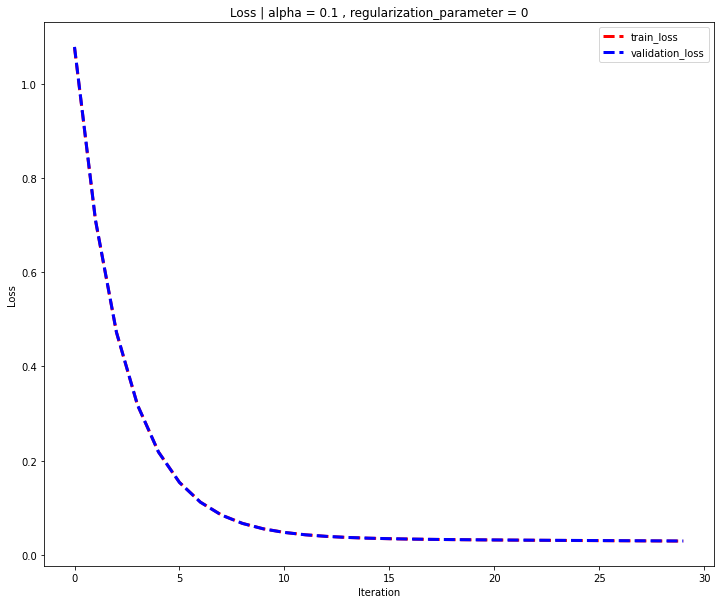

iteration:  25 alpha:  0.1 regularization_parameter:  0.1 Validation loss:  0.023662677103520605 Train loss:  0.02304841182518812


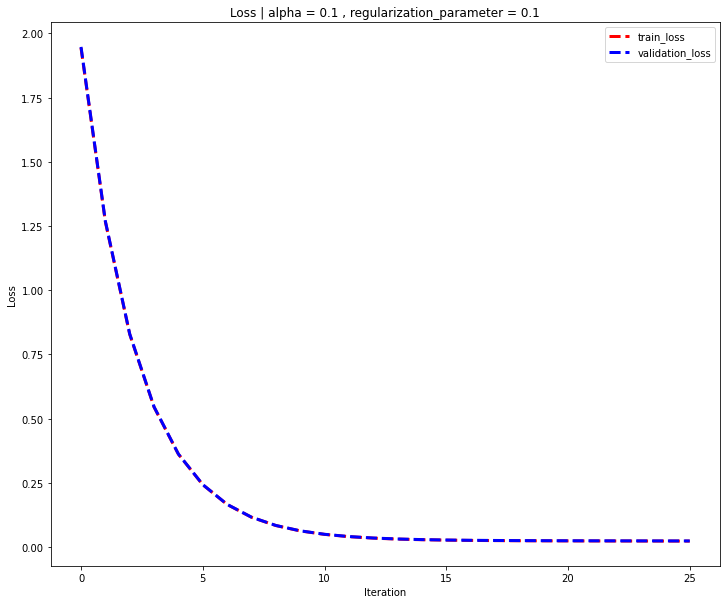

iteration:  31 alpha:  0.1 regularization_parameter:  1 Validation loss:  0.037827495220734926 Train loss:  0.03739445275573214


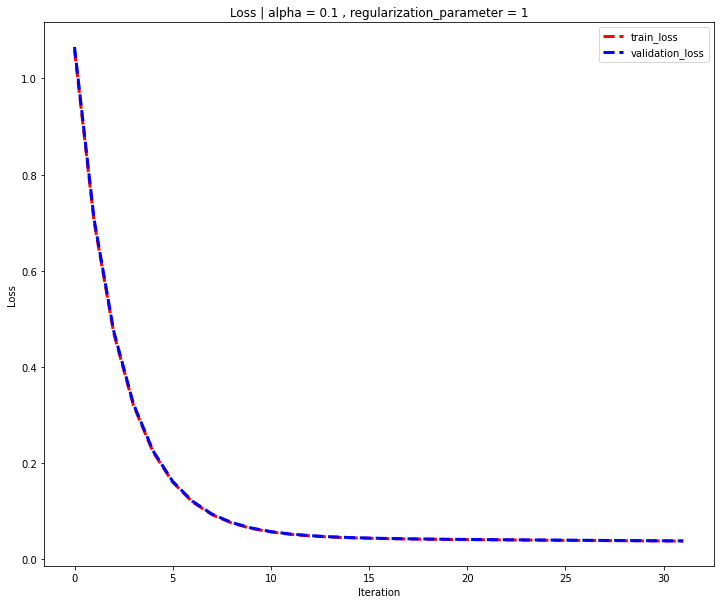

iteration:  44 alpha:  0.1 regularization_parameter:  10 Validation loss:  0.027664317103089878 Train loss:  0.026019438832885662


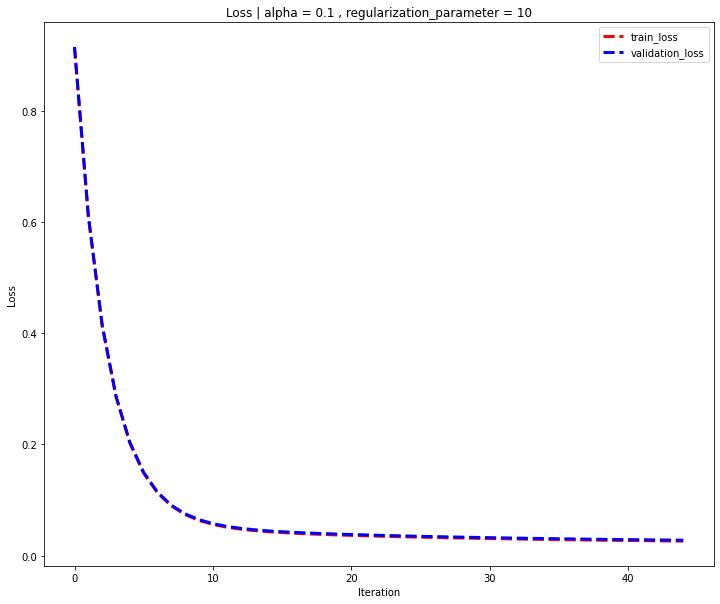

iteration:  31 alpha:  0.3 regularization_parameter:  0 Validation loss:  0.018800049241051654 Train loss:  0.01839648731650877


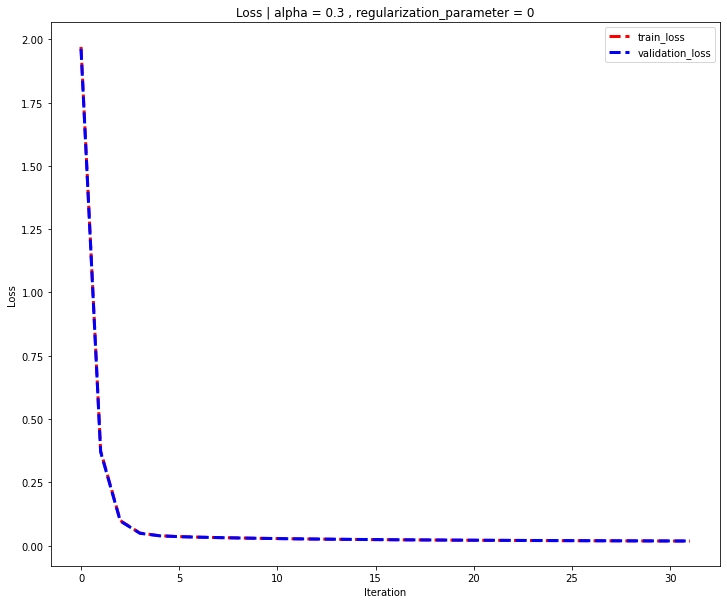

iteration:  29 alpha:  0.3 regularization_parameter:  0.1 Validation loss:  0.014122925010297988 Train loss:  0.013451389914066044


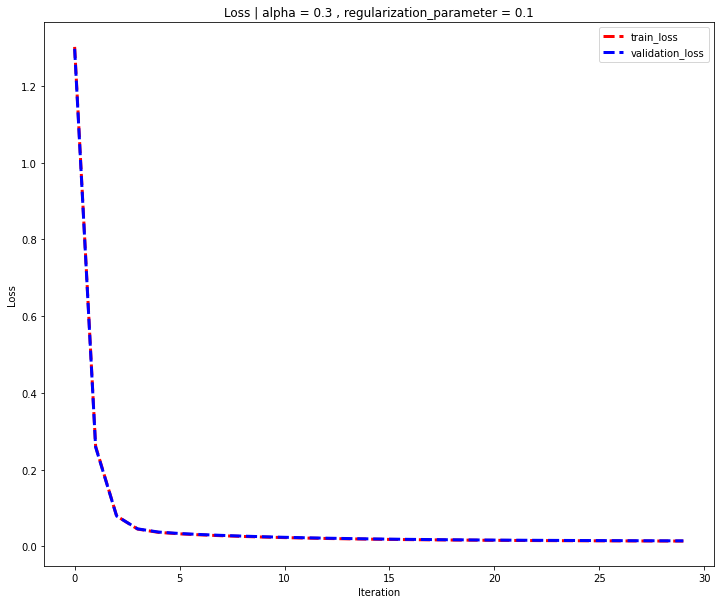

iteration:  34 alpha:  0.3 regularization_parameter:  1 Validation loss:  0.01999751605751841 Train loss:  0.019387438555600357


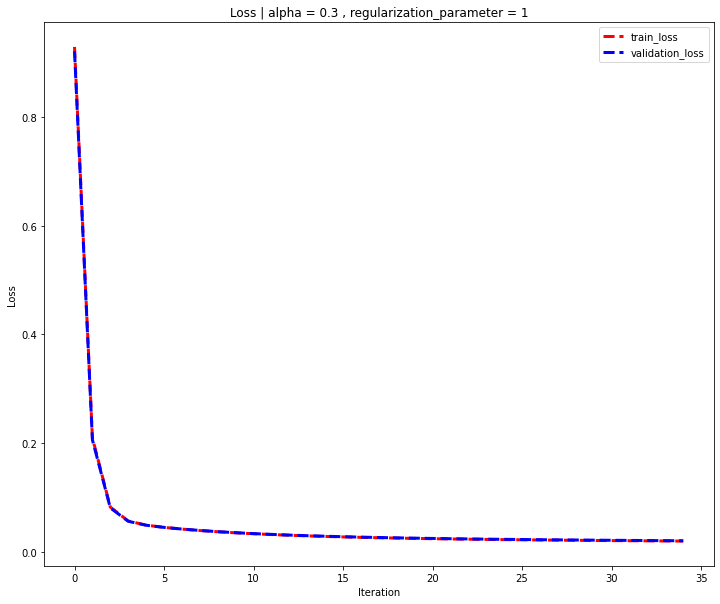

iteration:  19 alpha:  0.3 regularization_parameter:  10 Validation loss:  0.025742001351693355 Train loss:  0.02342725345889617


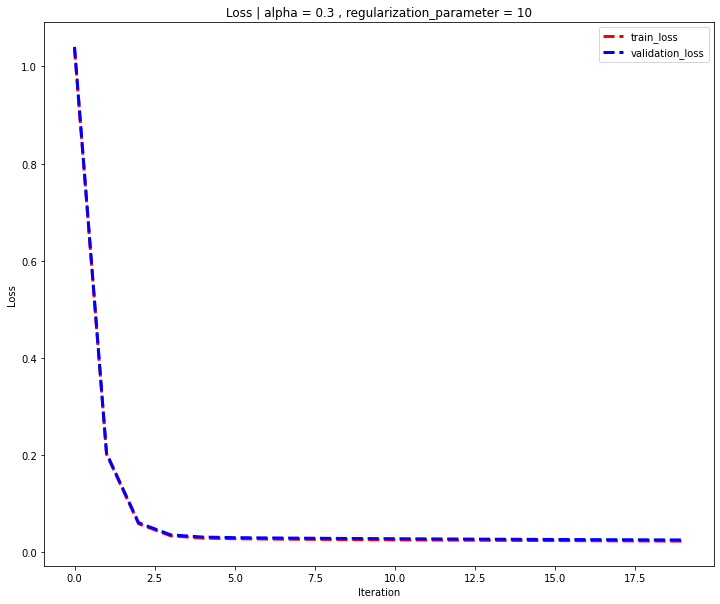

iteration:  35 alpha:  0.5 regularization_parameter:  0 Validation loss:  0.021887023900601155 Train loss:  0.021566978028042146


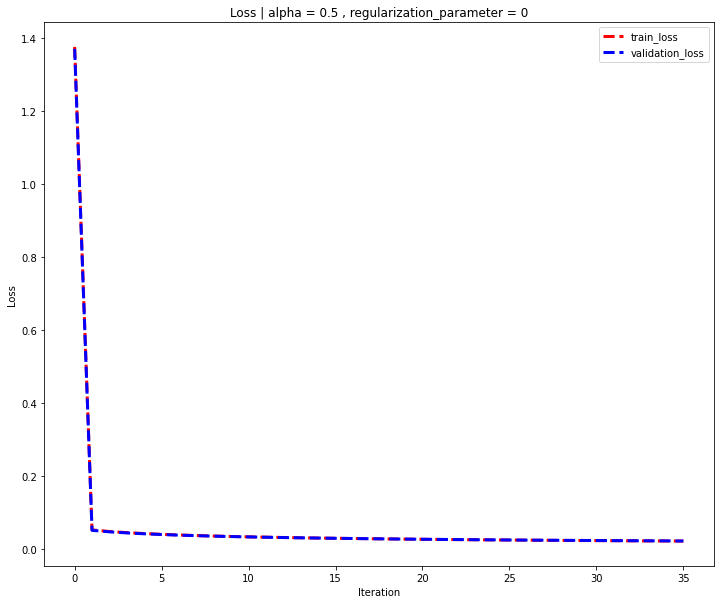

iteration:  35 alpha:  0.5 regularization_parameter:  0.1 Validation loss:  0.01984660303703664 Train loss:  0.019411370891027475


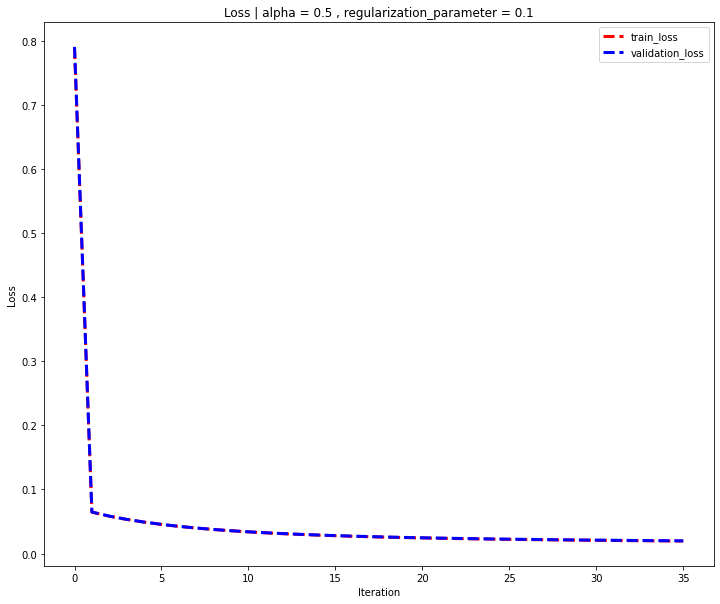

iteration:  33 alpha:  0.5 regularization_parameter:  1 Validation loss:  0.020884414980272437 Train loss:  0.020382142541499434


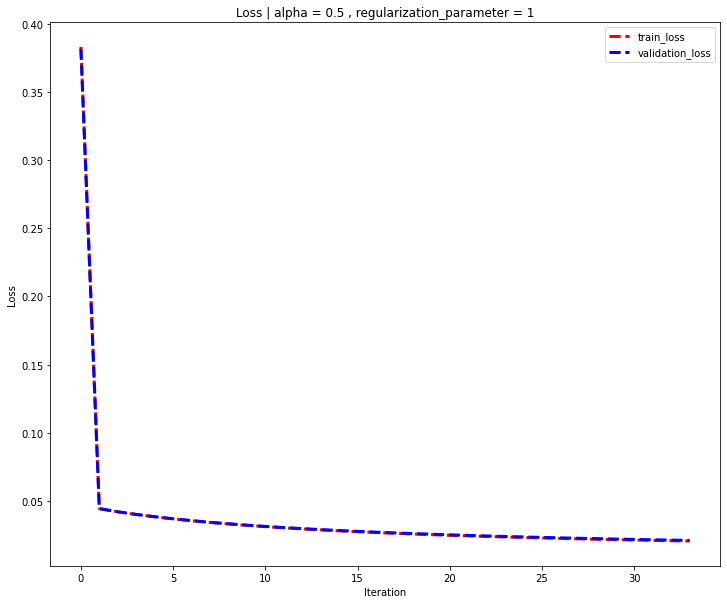

iteration:  28 alpha:  0.5 regularization_parameter:  10 Validation loss:  0.01653111146875901 Train loss:  0.014650398625803852


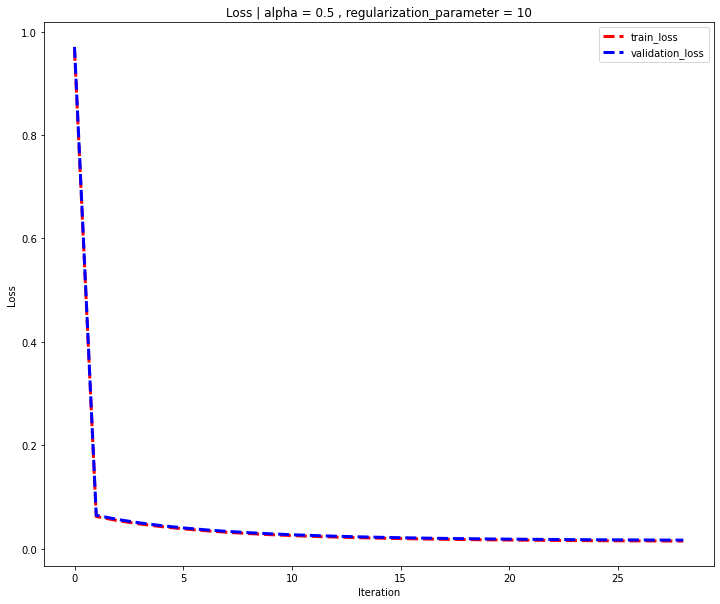

iteration:  22 alpha:  0.7 regularization_parameter:  0 Validation loss:  0.016044227856882552 Train loss:  0.015394389973806842


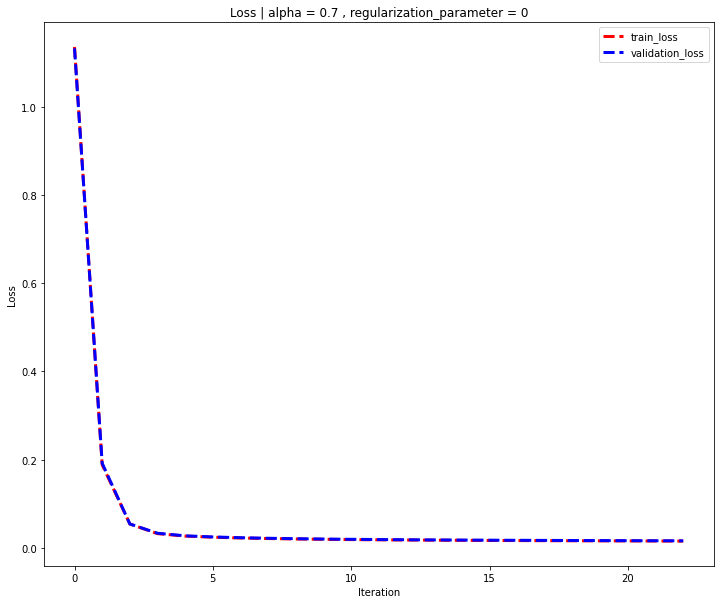

iteration:  26 alpha:  0.7 regularization_parameter:  0.1 Validation loss:  0.020535781828774552 Train loss:  0.020194784607527876


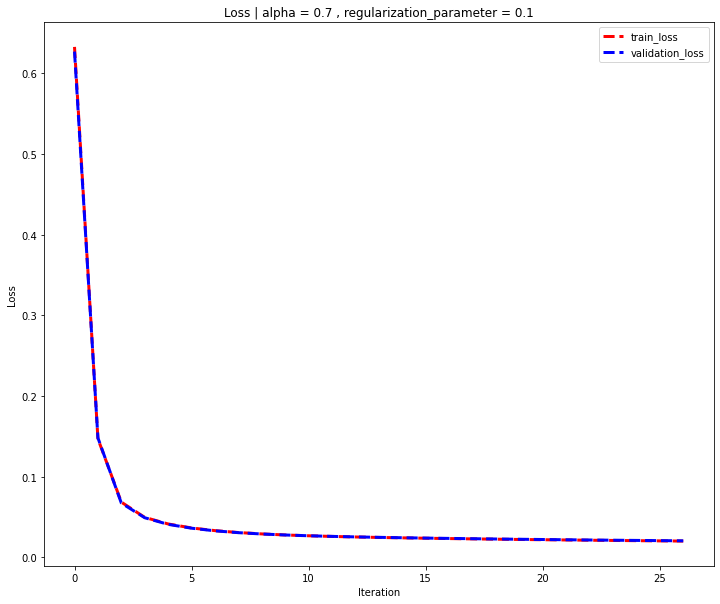

iteration:  16 alpha:  0.7 regularization_parameter:  1 Validation loss:  0.015915893992446056 Train loss:  0.015137987001073869


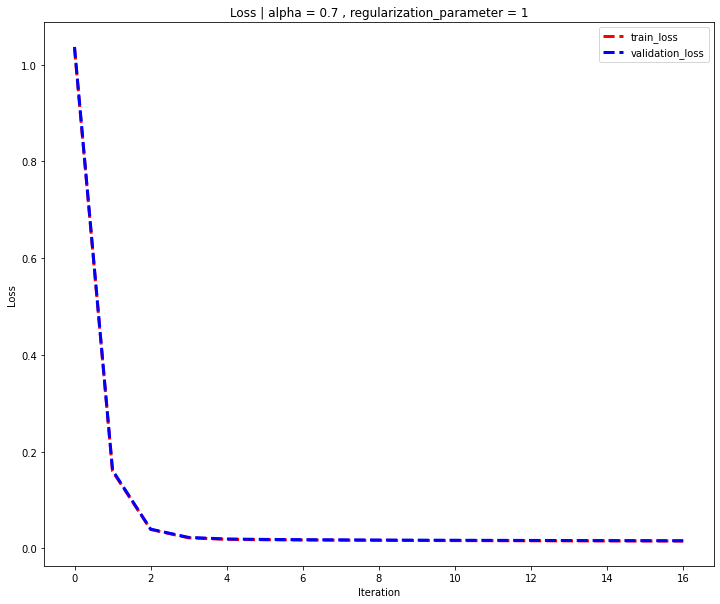

iteration:  27 alpha:  0.7 regularization_parameter:  10 Validation loss:  0.022855205234331172 Train loss:  0.02033803802875065


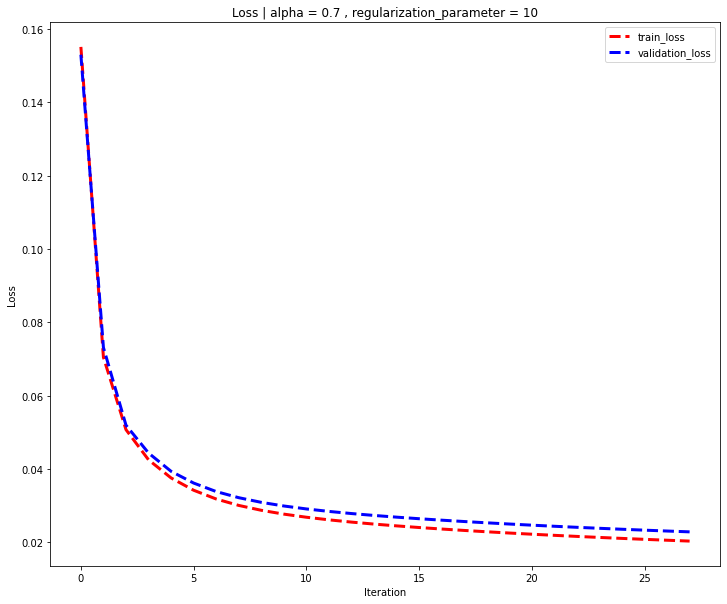

iteration:  66 alpha:  1 regularization_parameter:  0 Validation loss:  0.01400721962432327 Train loss:  0.013451357849457059


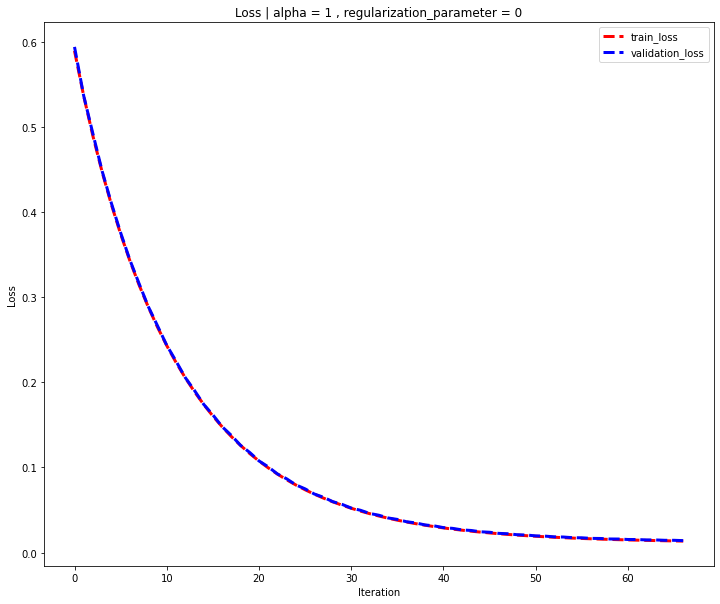

iteration:  53 alpha:  1 regularization_parameter:  0.1 Validation loss:  0.01585778048041657 Train loss:  0.014961181003274392


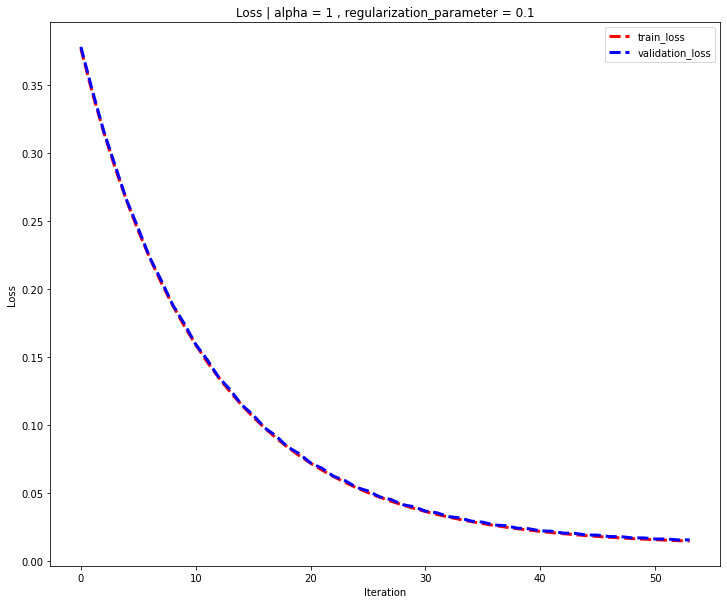

iteration:  58 alpha:  1 regularization_parameter:  1 Validation loss:  0.014711011159239213 Train loss:  0.013919964075222781


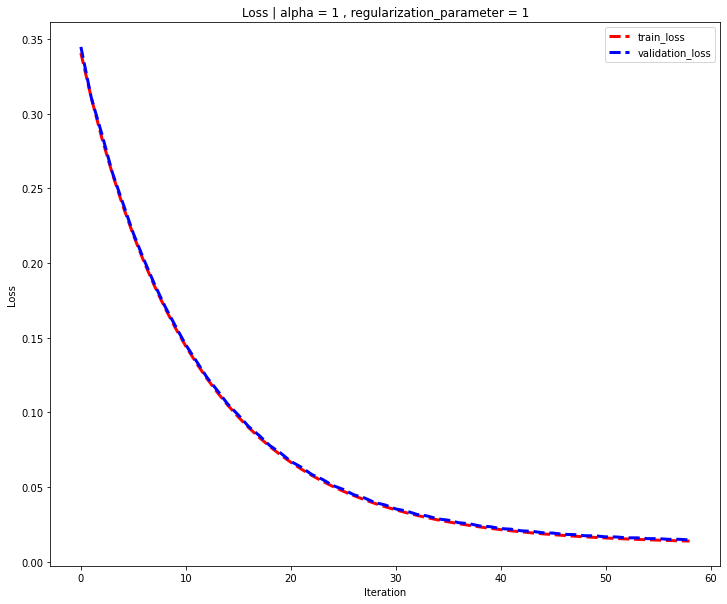

iteration:  77 alpha:  1 regularization_parameter:  10 Validation loss:  0.017222892696215745 Train loss:  0.01484884918809547


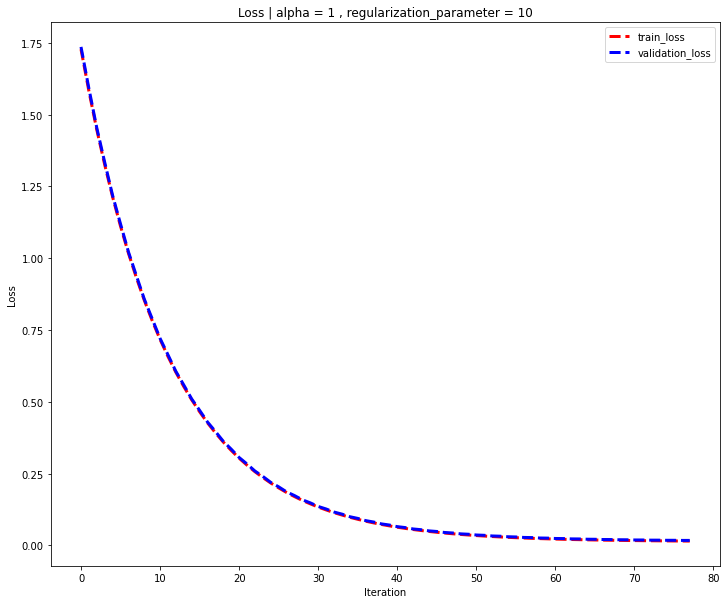

In [31]:
lambda_list = [0, 0.1, 1, 10]
alpha_list = [0.1, 0.3, 0.5, 0.7, 1]
alpha_lambda_coeff_loss_mse_df = pd.DataFrame(columns=["alpha", "lambda", "coeffs", "loss", "mse"])

# loss plot for each alpha and lambda
for alpha in alpha_list:
    for regul_param in lambda_list:
        random_theta = np.random.rand(x_train.shape[1])  # random values between 5 and 10
        last_theta, theta_history, train_loss_history, validation_loss_history = fit_linear_regression(x_train, y_train, x_test, y_test, random_theta , alpha=alpha, regularization_parameter=regul_param)
        plot_loss_train_validation(train_loss_history, validation_loss_history, alpha, regul_param)
        y_predict = linear_regression_predict(x_test, last_theta)
        mean_squared_error = calculate_mse(y_test, y_predict)
        alpha_lambda_coeff_loss_mse_df = alpha_lambda_coeff_loss_mse_df.append({"alpha": alpha, "lambda": regul_param, "coeffs": last_theta, "loss": validation_loss_history[-1], "mse": mean_squared_error}, ignore_index=True)

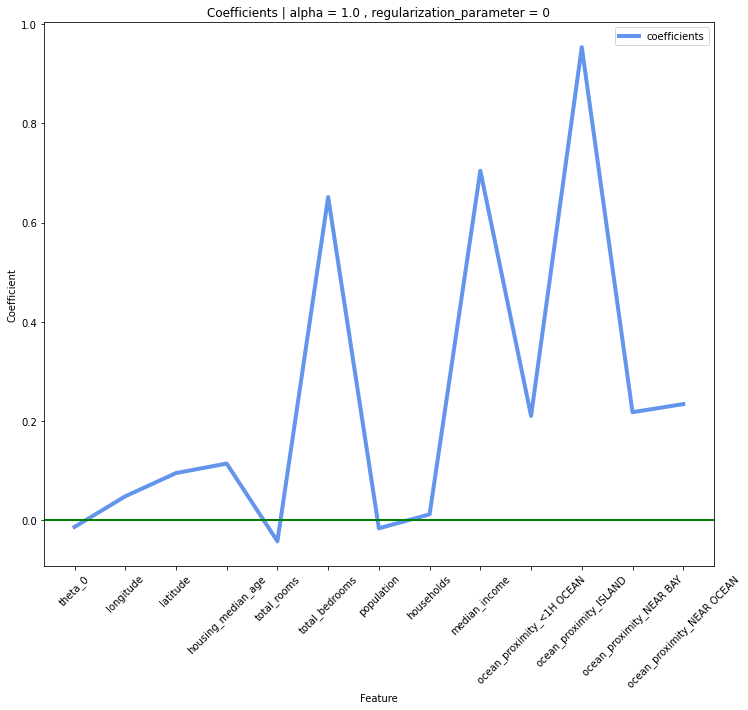

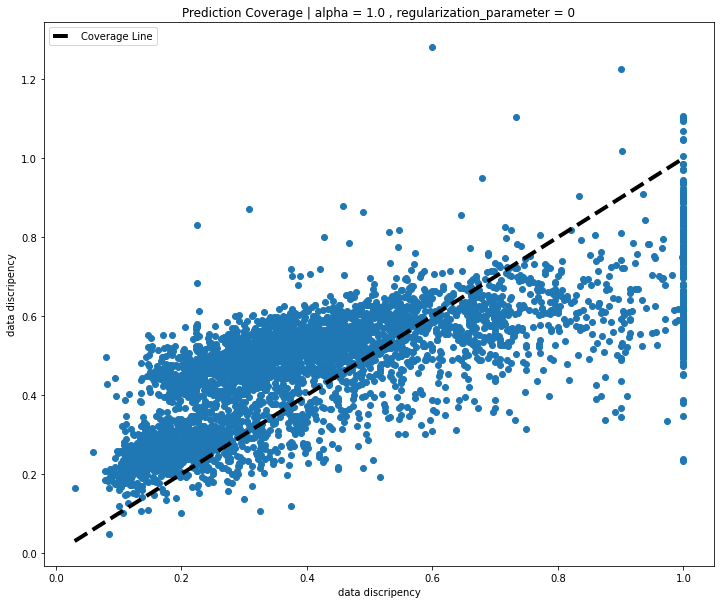

{'MSE': 0.02801443924864654, 'RMSE': 0.16737514525354874, 'MAE': 0.13543239850670735, 'R squared': 0.4777287605761328}


In [32]:
alpha, regul_param, coeffs, _ = get_train_fit_min_value(alpha_lambda_coeff_loss_mse_df, "loss")
# print("Best model Coefficients: ", coeffs)

y_predict = linear_regression_predict(x_test, coeffs)
loss = loss_function_with_regularization(x_test, y_predict, coeffs, regul_param)

plot_coeffs(feature_columns, coeffs, alpha, regul_param)
plot_prediction_coverage(y_test, y_predict, alpha, regul_param)

report_error_df = report_error(y_test, y_predict)
print(report_error_df)

## Q1 - Part H

In [33]:
dataset = load("housing.csv")
dataset = normalize_missing_values(dataset)
dataset = dataset.assign(median_house_value = dataset["median_house_value"] / dataset["median_house_value"].max())
last_column = dataset[["median_house_value"]]
dataset = remove_column(dataset, "median_house_value")

dataset["population_per_household"] = dataset["population"] / dataset["households"]
dataset["rooms_per_household"] = dataset["total_rooms"] / dataset["households"]

dataset = normalize_numerical_columns(dataset)
dataset = dummy_encode_categorical_column(dataset, "ocean_proximity")
dataset = remove_column(dataset, "ocean_proximity_INLAND")
dataset = concat_data(dataset, last_column)

dataset.insert(0, "theta_0", np.ones(dataset.shape[0]))
feature_columns = dataset.drop('median_house_value', axis=1).columns

X = dataset[feature_columns]
y = dataset["median_house_value"]

# print(">=========== split data to 60% train,20% validation and 20% test ===========<")
x_train, y_train, x_validation_test, y_validation_test = train_test_split(X, y, train_size=.6, shuffle=True)
x_validation, y_validation, x_test, y_test = train_test_split(x_validation_test, y_validation_test, test_size=.5, shuffle=True)


In [34]:
#  print max and min values of each column
for column in feature_columns:
    print(column, ": ", x_train[column].max(), x_train[column].min())

theta_0 :  1.0 1.0
longitude :  1.0 0.004980079681274621
latitude :  1.0 0.0010626992561103088
housing_median_age :  1.0 0.0
total_rooms :  1.0 0.0
total_bedrooms :  1.0 0.00015518311607697082
population :  1.0 0.0
households :  1.0 0.000164446637066272
median_income :  1.0 0.0
population_per_household :  1.0 4.642717124404186e-05
rooms_per_household :  0.9335349329103048 0.0
ocean_proximity_<1H OCEAN :  1 0
ocean_proximity_ISLAND :  1 0
ocean_proximity_NEAR BAY :  1 0
ocean_proximity_NEAR OCEAN :  1 0


In [35]:
x_train, y_train, x_validation, y_validation, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_validation), np.array(y_validation), np.array(x_test), np.array(y_test)
y_train, y_test, y_validation, = reshape_to_1d(y_train, y_test, y_validation)

In [36]:
y_train, y_test, y_validation

(array([0.17179966, 0.33279933, 0.6521987 , ..., 0.12059976, 0.53659893,
        0.97139806]),
 array([0.95439809, 0.28959942, 0.62499875, ..., 0.6999986 , 0.45999908,
        0.14439971]),
 array([0.41359917, 0.70839858, 0.27499945, ..., 0.17639965, 0.19659961,
        0.18959962]))

iteration:  159 alpha:  1.0 regularization_parameter:  0 Validation loss:  0.03456703866733953 Train loss:  0.038063572807617595


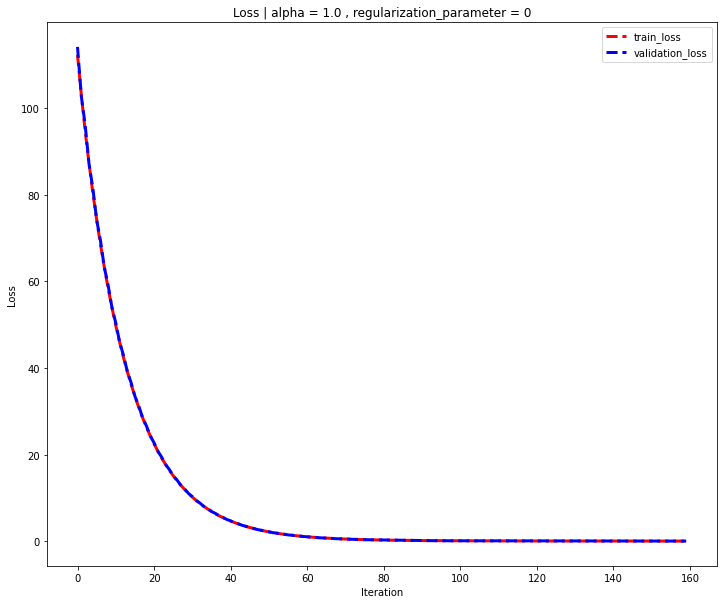

Loss value test set:  0.0


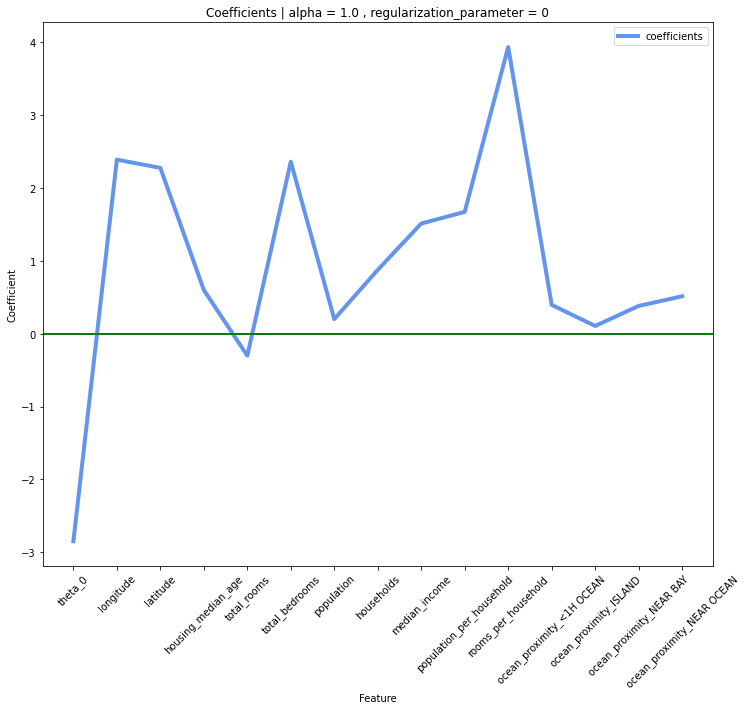

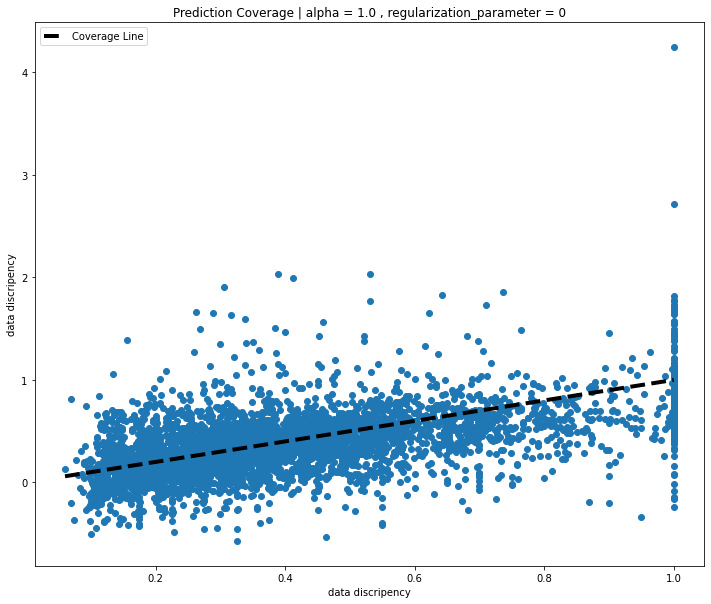

{'MSE': 0.0774119022311429, 'RMSE': 0.27822994488577774, 'MAE': 0.19963331450542543, 'R squared': -0.4927895569929961}


In [37]:
last_theta, _, train_loss_history, validation_loss_history = fit_linear_regression(x_train, y_train, x_validation, y_validation, np.random.rand(x_train.shape[1])* 10, alpha=alpha, regularization_parameter=regul_param)
plot_loss_train_validation(train_loss_history, validation_loss_history, alpha, regul_param)

y_predict = linear_regression_predict(x_test, last_theta)
loss = loss_function_with_regularization(x_test, y_predict, last_theta, regul_param)

print("Loss value test set: ", loss)

plot_coeffs(feature_columns, last_theta, alpha, regul_param)
plot_prediction_coverage(y_test, y_predict, alpha, regul_param)

report_error_df = report_error(y_test, y_predict)
print(report_error_df)

In [38]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score

In [39]:
dataset = load("housing.csv")
dataset = normalize_missing_values(dataset)
dataset = dataset.assign(median_house_value = dataset["median_house_value"] / dataset["median_house_value"].max())
last_column = dataset[["median_house_value"]]
dataset = remove_column(dataset, "median_house_value")
dataset = normalize_numerical_columns(dataset)
dataset = dummy_encode_categorical_column(dataset, "ocean_proximity")
dataset = remove_column(dataset, "ocean_proximity_INLAND")
dataset = concat_data(dataset, last_column)

dataset.insert(0, "theta_0", np.ones(dataset.shape[0]))
feature_columns = dataset.drop('median_house_value', axis=1).columns
# print(">====================================================<")

X = dataset[feature_columns]
y = dataset["median_house_value"]

feature_columns = list(dataset.columns[:-1])
x_train, y_train, x_test, y_test = train_test_split(X, y, train_size=.6, shuffle=True)


In [40]:
alpha_values = [0.1, 0.3, 0.5, 0.7, 1]
l1_ratio = [0, .1, 1, 10]

#######################################################################
#                                                                     #
#                     Without Regularization                          #
#                                                                     #
#######################################################################

regressor = LinearRegression(fit_intercept=True)
regressor_fit = regressor.fit(x_train, y_train)
regressor_fit_coeffs = regressor_fit.coef_
# cross_val_score(model, x_train, y_train, scoring='neg_mean_squared_error', cv=10)


#######################################################################
#                                                                     #
#                            Ridge                                    #
#                                                                     #
#######################################################################

mse_list = []
model_list = []
for alpha in alpha_values:
    ridge_regression = Ridge(alpha=alpha, fit_intercept=False, normalize=False, copy_X=True, tol=0.001, solver='auto', random_state=None)
    mse = cross_val_score(ridge_regression, x_train, y_train, scoring='neg_mean_squared_error', cv=10)
    mse_list.append(mse.mean())

print("mse_list:", mse_list)
min_mse_index = np.argmin(mse_list)
print("min_mse_index:", min_mse_index)

best_ridge_model = Ridge(alpha=alpha_values[min_mse_index], fit_intercept=False, normalize=False, copy_X=True, tol=0.001, solver='auto', random_state=None)
best_ridge_model_fit = best_ridge_model.fit(x_train, y_train) 
best_ridge_coeffs = best_ridge_model_fit.coef_

print("Ridge Regression report:")
print("alpha:", alpha_values[min_mse_index], "| mse:", mse_list[min_mse_index], "| coefficients:", best_ridge_coeffs)

#######################################################################
#                                                                     #
#                            Lasso                                    #
#                                                                     #
#######################################################################

mse_list = []
for alpha in alpha_values:
    lasso_regression = Lasso(alpha=alpha, fit_intercept=False, precompute=True, copy_X=True, tol=0.0001, selection='random')
    mse = cross_val_score(lasso_regression, x_train, y_train, scoring='neg_mean_squared_error', cv=5)
    mse_list.append(mse.mean())

print("mse_list:", mse_list)
min_mse_index = np.argmin(mse_list)
print("min_mse_index:", min_mse_index)

best_lasso_regression_model = Lasso(alpha=alpha_values[min_mse_index], fit_intercept=False, normalize=True, precompute=True, copy_X=True, tol=0.0001, warm_start=False, random_state=None, selection='cyclic')
best_lasso_regression_fit = best_lasso_regression_model.fit(x_train, y_train) 
best_lasso_coeffs = best_lasso_regression_fit.coef_

print("Lasso Regression report:")
print("alpha:", alpha_values[min_mse_index], "| mse:", mse_list[min_mse_index], "| coefficients:", best_lasso_coeffs)


#######################################################################
#                                                                     #
#                            ElasticNet                               #
#                                                                     #
#######################################################################

mse_list = []
for alpha in alpha_values:
    for ratio in l1_ratio:
        elasticnet_regression = ElasticNet(alpha=alpha, l1_ratio=ratio, fit_intercept=False, normalize=False, precompute=False, copy_X=True)
        mse = cross_val_score(lasso_regression, x_train, y_train, scoring='neg_mean_absolute_error', cv=5)
        mse_list.append([mse.mean(), alpha, ratio])

min_mse_index = np.argmin(mse_list[0])
best_elasticnet_regression_model = ElasticNet(alpha=mse_list[min_mse_index][1], l1_ratio=mse_list[min_mse_index][2], fit_intercept=False, copy_X=True, tol=0.0001)
best_elasticnet_regression_fit = best_elasticnet_regression_model.fit(x_train, y_train)
best_elasticnet_coeffs = best_elasticnet_regression_fit.coef_

print("ElasticNet Regression report:")
print("alpha:", mse_list[min_mse_index][1], "| l1_ratio:", mse_list[min_mse_index][2], "| mse:", mse_list[min_mse_index][0], "| coefficients:", best_elasticnet_coeffs)

mse_list: [-0.0190154918845956, -0.019005001688338193, -0.019021562678135435, -0.019052759452630064, -0.01911322821137803]
min_mse_index: 4
Ridge Regression report:
alpha: 1 | mse: -0.01911322821137803 | coefficients: [[ 0.39193667 -0.48921208 -0.43054017  0.10756068 -0.28170188  0.86051292
  -1.8064005   0.4630693   1.11900181  0.08468073  0.3382895   0.07914078
   0.10019311]]
mse_list: [-0.06381325701543886, -0.1438133264762044, -0.22628307098792627, -0.22628307098792627, -0.22628307098792627]
min_mse_index: 2
Lasso Regression report:
alpha: 0.5 | mse: -0.22628307098792627 | coefficients: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ElasticNet Regression report:
alpha: 0.1 | l1_ratio: 0 | mse: -0.41530284121526406 | coefficients: [0.17657043 0.04897174 0.04079013 0.08714271 0.02822085 0.02240719
 0.00489268 0.02277613 0.20448701 0.13239432 0.00179111 0.09636495
 0.1074554 ]


In [41]:
# regressor_fit_coeffs[0]
# best_elasticnet_coeffs
# best_lasso_coeffs
# best_ridge_coeffs[0]
# coeffs[1:]

                            Assignment Model  SKLearn - witout Regularization  \
theta_0                            -0.013248                         0.000000   
longitude                           0.048557                        -0.535022   
latitude                            0.095344                        -0.476555   
housing_median_age                  0.114488                         0.106337   
total_rooms                        -0.042079                        -0.411647   
total_bedrooms                      0.651630                         1.034549   
population                         -0.015978                        -2.674922   
households                          0.012230                         0.798714   
median_income                       0.704582                         1.133009   
ocean_proximity_<1H OCEAN           0.210685                         0.077661   
ocean_proximity_ISLAND              0.953802                         0.389354   
ocean_proximity_NEAR BAY    

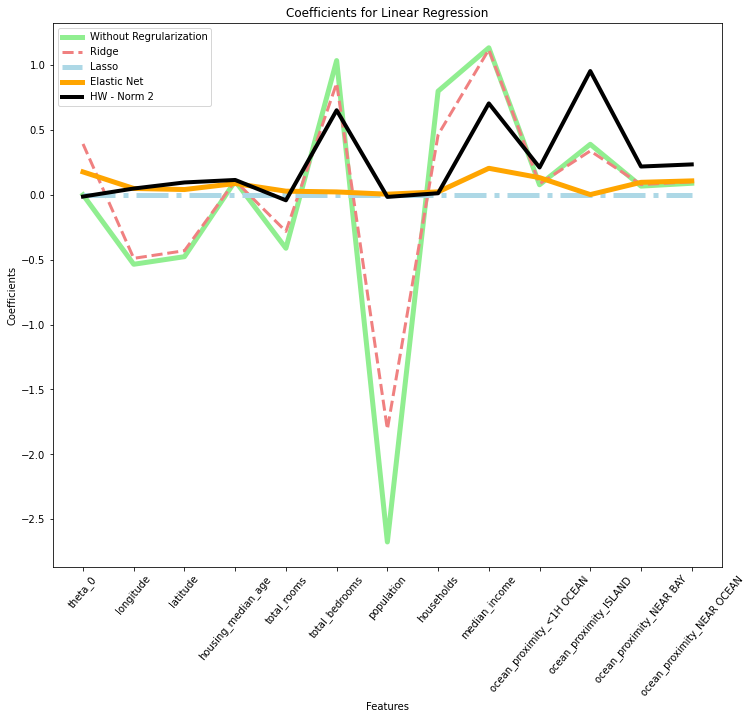

In [42]:
comparing_models = pd.DataFrame({
    'Assignment Model': coeffs,
    'SKLearn - witout Regularization': regressor_fit_coeffs[0],
    'SKLearn - Ridge': best_ridge_coeffs[0],
    'SKLearn - Lasso': best_lasso_coeffs,
    'SKLearn - ElasticNet': best_elasticnet_coeffs}, index=feature_columns)

# Highlighting coefficient estimates with value '0'
comparing_models.style.background_gradient(cmap='coolwarm')
print(comparing_models)

len_of_feature_columns = len(feature_columns)
plt.figure(figsize=(12,10))
# plt.plot(range(len(feature_columns)),comparing_models[''], label='my_model')

plt.plot(range(len_of_feature_columns),comparing_models['SKLearn - witout Regularization'], label='Without Regrularization', color='lightgreen', linewidth=5)
plt.plot(range(len_of_feature_columns),comparing_models['SKLearn - Ridge'], label='Ridge', color='lightcoral', linestyle='--', linewidth=3)
plt.plot(range(len_of_feature_columns),comparing_models['SKLearn - Lasso'], label='Lasso', color='lightblue', linestyle='dashdot', linewidth=5)
plt.plot(range(len_of_feature_columns),comparing_models['SKLearn - ElasticNet'], label='Elastic Net', color='orange', linewidth=5)
plt.plot(range(len_of_feature_columns),comparing_models['Assignment Model'], label='HW - Norm 2', color='black', linestyle='-', linewidth=4)
plt.xticks(range(len(feature_columns)),feature_columns,rotation=50)
plt.title("Coefficients for Linear Regression")
plt.ylabel("Coefficients")
plt.xlabel("Features")
plt.legend()
plt.show()
 

# Q2: Logistic Regression

In [137]:
def logistic(x_data, theta):
    return 1 / (1 + np.exp(-np.dot(x_data, theta)))

def hypothesis(x_data, weights):
    return logistic(x_data, weights)

def logistic_cost_function_regularized(x_data, y_data, weights, regul_param):
    m_number_of_samples = len(x_data)
    hypothesis_value = hypothesis(x_data, weights)
    j_theta_1 = (-1 / m_number_of_samples) * np.sum(y_data * np.log(hypothesis_value) + (1 - y_data) * np.log(1 - hypothesis_value))
    j_theta_2 = (regul_param / (2 * m_number_of_samples)) * np.sum(np.square(weights[1:]))
    return j_theta_1 + j_theta_2

def gradient_descent(x_train, y_train, theta, alpha, regularization_parameter, verbose):
    """ #### Gradient_descent
    @param x_train: train data
    @param y_train: train label
    @param theta: wieghts
    @param alpha: learning rate
    @param regularization_paramet: lambda regularization parameter
    @return: updated wieghts and loss function value
    """
    iteration = 0
    theta_list = []
    train_cost_list = []
    m_number_of_samples = x_train.shape[0]

    theta_list.append([*theta])
    train_cost_list.append(logistic_cost_function_regularized(x_train.copy(), y_train.copy(), theta, regularization_parameter))

    while True:
        hypothesis_value = logistic(x_train, theta)

        # updating θ_j with regularization
        for j_index in range(theta.shape[0]):
            if j_index != 0:
                theta[j_index] -= alpha *  (1 / m_number_of_samples) * (np.dot(hypothesis_value - y_train, x_train[:, j_index]) + regularization_parameter * theta[j_index])
            else:
                theta[j_index] -= alpha *  (1 / m_number_of_samples) * (np.dot(hypothesis_value - y_train, x_train[:, j_index]))

        iteration = iteration + 1

        theta_list.append([*theta])
        train_cost_list.append(logistic_cost_function_regularized(x_train.copy(), y_train.copy(), theta, regularization_parameter))

        if len(theta_list) >= 2:
            # calculate delta(J(θ) - J(θ_old))
            max_delta = 0
            for j_index in range(theta.shape[0]):
                delta = abs(theta_list[iteration][j_index] - theta_list[iteration - 1][j_index])
                if delta > max_delta:
                    max_delta = delta
            # for each theta[j_index] if max_delta > 0.001 then return theta
            if max_delta <= 0.0001:
                if verbose:
                    print("iteration: ", iteration, "alpha: ", alpha, "regularization_parameter: ", regularization_parameter, "Train loss: ", train_cost_list)
                return theta, theta_list, train_cost_list, iteration

def fit_logistic_regression(x_train, y_train, theta, alpha, regularization_parameter, verbose):
    if theta is None:
            theta = np.random.rand(x_train.shape[1]) 
    return gradient_descent(x_train, y_train, theta, alpha, regularization_parameter, verbose)

def predict_logistic_regression(x_data, weights):
    return np.where(logistic(x_data, weights) > 0.5, 1, 0)

def plot_logistic_regression(x_test, y_test, weights, column_number):
    x_test[:, column_number] = np.sort(x_test[:, column_number])
    y_test = np.sort(y_test)
    y_predict = logistic(x_test, weights)
    y_predict = np.sort(y_predict)

    plt.figure(figsize=(12, 10))
    x_range = np.linspace(x_test[:, column_number].min(), x_test[:, column_number].max(), x_test.shape[0])
    plt.plot(x_range, y_predict, 'k', label="logistic", lw=4)
    plt.scatter(x_test[:, column_number], y_test, label="scatter", color='g', s=50)
    plt.axhline(y=0.5, color='k')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc=2)
    plt.show()
    # plt.close()

def confusion_matrix(y_true, y_pred):
    c_matrix = np.zeros((2, 2)) # 2x2 matrix as problem is 2-class
    for i in range(len(y_true)):
        if y_true[i] == 1 and y_pred[i] == 1: # TP
            c_matrix[0][0] += 1
        elif y_true[i] == 0 and y_pred[i] == 1: # FP
            c_matrix[0][1] += 1
        elif y_true[i] == 1 and y_pred[i] == 0: # FN
            c_matrix[1][0] += 1
        elif y_true[i] == 0 and y_pred[i] == 0: # TN
            c_matrix[1][1] += 1
        TP, FP, FN, TN = c_matrix[0][0], c_matrix[0][1], c_matrix[1][0], c_matrix[1][1]
    return TP, FP, FN, TN

def show_metrics(confusion_result):
    TP, FP, FN, TN = confusion_result
    print("\nConfusion Matrix:")
    print("\t\tPredicted")
    print("\t\t\t0\t1")
    print("Actual")
    print("\t0\t\t{}\t{}".format(TP, FP))
    print("\t1\t\t{}\t{}".format(FN, TN))
    print(">===================================================<")
    print("Accuracy: ", np.round((TP + TN) / (TP + TN + FP + FN), 3))
    print("Precision: ", np.round(TP / (TP + FP), 3))
    print("Recall: ", np.round(TP / (TP + FN), 3))
    print("F1 Score: ", np.round(2 * TP / (2 * TP + FP + FN), 3))
    print(">===================================================<")


def calculate_accuracy(confusion_matrix_result):
    TP, FP, FN, TN = confusion_matrix_result
    return np.round((TP + TN) / (TP + TN + FP + FN), 5)

def calculate_precision(confusion_matrix_result):
    TP, FP, FN, TN = confusion_matrix_result
    return np.round(TP / (TP + FP), 5)

def calculate_recall(confusion_matrix_result):
    TP, FP, FN, TN = confusion_matrix_result
    return np.round(TP / (TP + FN), 5)

def calculate_f_beta_score(confusion_matrix_result, beta=1):
    """
    ### Calculates the F-β score (the weighted harmonic mean of precision and recall).
    ### A perfect model has an F-score of 1.
    """
    TP, FP, FN, TN = confusion_matrix_result
    return np.round( (1 + beta**2) * TP / ((1 + beta**2) * TP + (beta**2) * FP + FN), 5)

def calculate_metrics(y_true, y_pred):
    cm_result = confusion_matrix(y_true, y_pred)
    return calculate_accuracy(cm_result), calculate_precision(cm_result), calculate_recall(cm_result), calculate_f_beta_score(cm_result), cm_result

def plot_iteration_per_alpha(iteration_per_alpha_list):
    alpha_list = np.array(iteration_per_alpha_list)[:, 0]
    iteration_list = np.array(iteration_per_alpha_list)[:, 1]
    plt.figure(figsize=(12, 10))
    plt.plot(alpha_list, iteration_list, 'k', label="logistic", lw=4)
    plt.xticks(alpha_list)
    plt.xlabel('alpha')
    plt.ylabel('iteration')
    plt.legend(loc=2)
    plt.savefig("./images/iteration_per_alpha.png")
    plt.title("Iteration per Alphas")
    plt.show()
    # plt.close()

def plot_metrics(accumulated_metrics):
    alpha_list = np.array(accumulated_metrics)[:, 0]
    accuracy_list = np.array(accumulated_metrics)[:, 2]
    precision_list = np.array(accumulated_metrics)[:, 3]
    recall_list = np.array(accumulated_metrics)[:, 4]
    f1_list = np.array(accumulated_metrics)[:, 5]
    plt.figure(figsize=(12, 10))
    plt.plot(alpha_list, accuracy_list, 'k', label="accuracy", lw=4)
    plt.plot(alpha_list, precision_list, 'r', label="precision", lw=4)
    plt.plot(alpha_list, recall_list, 'g', label="recall", lw=4)
    plt.plot(alpha_list, f1_list, 'b', label="f1_score", lw=4)
    # write text values on the plot
    for index in range(len(alpha_list)):
        plt.text(alpha_list[index], accuracy_list[index], str(accuracy_list[index]))
        plt.text(alpha_list[index], precision_list[index], str(precision_list[index]))
        plt.text(alpha_list[index], recall_list[index], str(recall_list[index]))
        plt.text(alpha_list[index], f1_list[index], str(f1_list[index]))

    plt.xlabel('alpha')
    plt.ylabel('metrics')
    plt.legend(loc=2)
    plt.show()
    # plt.close()

def k_fold(x_data, y_data, k_fold_number, shuffle=True, random_state=None):
    if random_state != None:
        np.random.seed(random_state)

    dataset = concat_data(x_data, y_data)
    if shuffle == True:
        dataset = dataset.sample(frac=1).reset_index(drop=True)
    dataset_size = len(dataset)
    fold_size = int(dataset_size / k_fold_number)
    indices = np.arange(dataset_size)
    if k_fold_number <= 1:
        raise ValueError("K-fold cross validation requires at least 2 folds")
    else:
        for index in range(k_fold_number):
            test_indices = indices[index * fold_size : (index + 1) * fold_size]
            train_indices =  np.delete(indices, test_indices)
            x_train = dataset.iloc[train_indices, :-1].reset_index(drop=True)
            y_train = dataset.iloc[train_indices, -1].reset_index(drop=True)
            x_test = dataset.iloc[test_indices, :-1].reset_index(drop=True)
            y_test = dataset.iloc[test_indices, -1].reset_index(drop=True)
            yield x_train, y_train, x_test, y_test

def cross_validation(x_data, y_data, k_fold_number, scoring, initial_theta, shuffle=True, alpha=0.1, lambda_param=1, verbose=True):
    """ ### Cross validation for logistic regression
    """

    if initial_theta is None:
        initial_theta = np.random.rand(x_data.shape[1]) * 10 + 5 # random values between 5 and 10

    k_fold_data = k_fold(x_data, y_data, k_fold_number, shuffle)

    metric_df = pd.DataFrame(columns=['alpha', 'lambda_param', 'accuracy', 'precision', 'recall', 'f1_score', 'loss', 'iteration'])
    average_metric_df = pd.DataFrame(columns=['alpha', 'lambda_param', 'accuracy', 'precision', 'recall', 'f1_score', 'loss', 'iteration'])

    # iterate through the data
    for x_train, y_train, x_test, y_test in k_fold_data:

        x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)
        y_train, y_test = reshape_to_1d(y_train, y_test)

        # train model
        coeffs, theta_history, train_loss_history, iteration = fit_logistic_regression(x_train, y_train, initial_theta , alpha=alpha, regularization_parameter=1, verbose=verbose)
        last_loss = train_loss_history[-1]
        y_predict = predict_logistic_regression(x_test, coeffs)

        # calculate metrics
        accuracy, precision, recall, f1_score, cm_result = calculate_metrics(y_test, y_predict)
        metric_df = metric_df.append({
            'alpha': alpha,
            'lambda_param': lambda_param,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'loss': last_loss,
            'iteration': iteration,
            'coeffs': coeffs
        }, ignore_index=True)

    iteration_mean = metric_df['iteration'].mean()
    min_loss_index = metric_df.loc[metric_df['loss'].idxmin()]
    coeffs = min_loss_index['coeffs']

    metric_df = metric_df.drop(columns=['coeffs'])
    metric_df = metric_df.drop(columns=['iteration'])

    average_metric_df = metric_df.groupby(['alpha', 'lambda_param']).mean().reset_index()
    return average_metric_df, coeffs, iteration_mean

def get_train_fit_min_value(dataframe, score_method):
    min_value_index = dataframe[score_method].idxmin()
    best_linear_regression_parameters = dataframe.loc[min_value_index]
    alpha = best_linear_regression_parameters["alpha"]
    regul_param = best_linear_regression_parameters["lambda_param"]
    coeffs = best_linear_regression_parameters["coeffs"]
    loss = best_linear_regression_parameters["loss"]
    iteration = best_linear_regression_parameters["iteration"]
    return alpha, regul_param, coeffs, loss, iteration


In [138]:
# print(">======================= Loading ====================<")
dataset = load("data_banknote_authentication.txt", False)
# print(">=====================================================")

# print(">============ Data without missing values ===========<")
dataset = normalize_missing_values(dataset)
dataset.rename(columns={0: 'column_1', 1: 'column_2', 2: 'column_3', 3: 'column_4', 4:'label' }, inplace=True)
# print_dataset(dataset)
# dataset.tail()
# print(">=====================================================")

# print(">============= Normalize numerical columns ==========<")
# label_column = dataset[["label"]]
# dataset = remove_column(dataset, "label")
# dataset = normalize_numerical_columns(dataset)
# dataset = concat_data(dataset, label_column)

dataset.insert(0, "theta_0", np.ones(dataset.shape[0]))
feature_columns = dataset.drop('label', axis=1).columns
X = dataset[feature_columns]
y = dataset["label"]
# print(">====================================================<")

# print(">=========== split data to 60% train,20% validation and 20% test ===========<")
# x_train, y_train, x_validation_test, y_validation_test = train_test_split(X, y, train_size=.6, shuffle=True)
# x_validation, y_validation, x_test, y_test = train_test_split(x_validation_test, y_validation_test, test_size=.5, shuffle=True)

# print(feature_columns, x_train.head())

# x_train, y_train, x_validation, y_validation, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_validation), np.array(y_validation), np.array(x_test), np.array(y_test)
# y_train, y_test, y_validation, = reshape_to_1d(y_train, y_test, y_validation)
# # print(">====================================================<")

x_train, y_train, x_test, y_test = train_test_split(X.copy(), y.copy(), test_size=.6, shuffle=True)
x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)
y_train, y_test = reshape_to_1d(y_train, y_test)

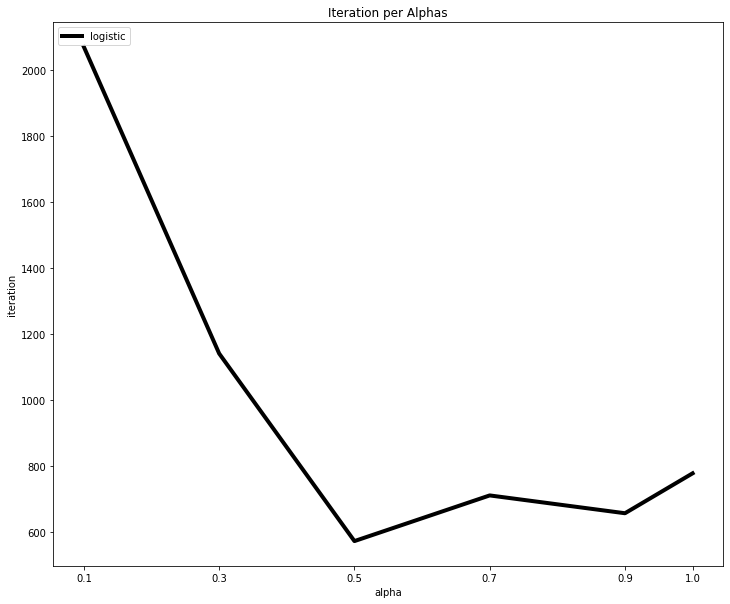

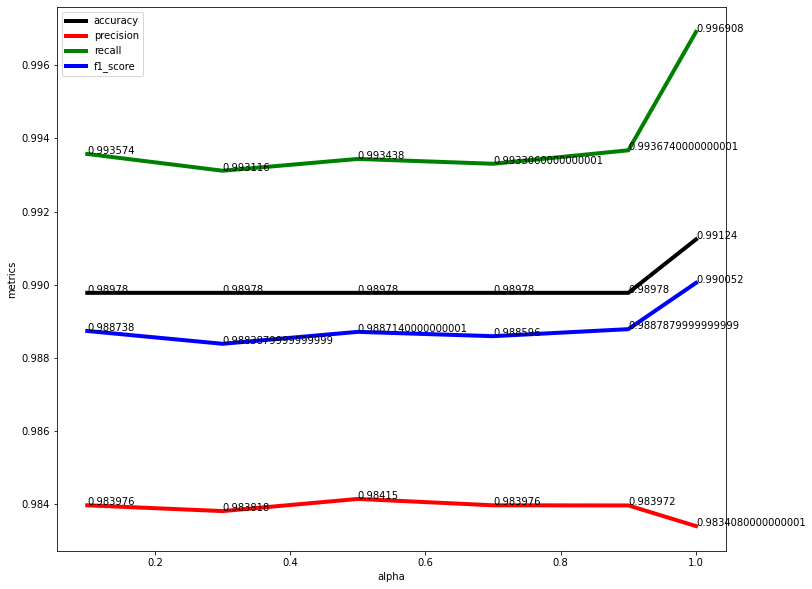

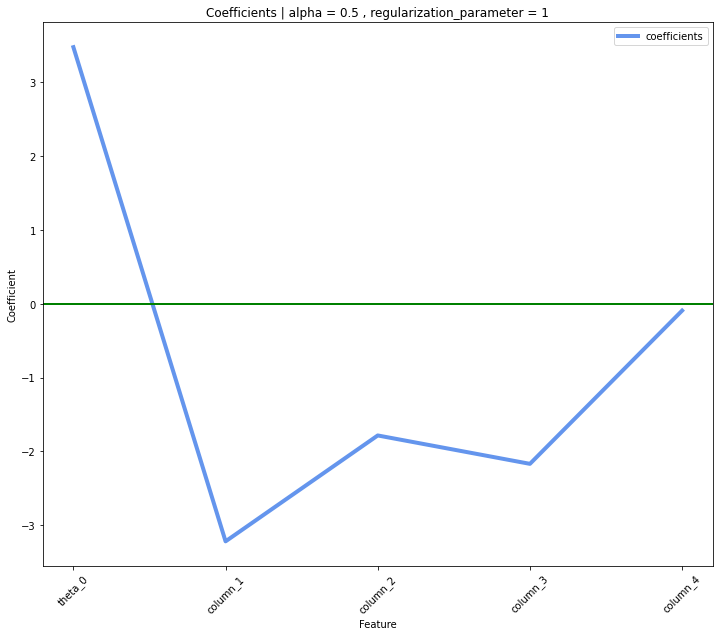


Confusion Matrix:
		Predicted
			0	1
Actual
	0		361.0	6.0
	1		2.0	455.0
>===================================================<
Accuracy:  0.99
Precision:  0.984
Recall:  0.994
F1 Score:  0.989
>===================================================<
                                                         value
alpha                                                      0.5
regul_param                                                  1
loss                                                  0.032647
iteration                                                572.6
accuracy                                               0.99029
precision                                              0.98365
recall                                                 0.99449
f1_score                                               0.98904
coeffs       [3.4762727057736376, -3.2181152749060953, -1.7...
MSE                                                   0.009709
MAE                                                   0.0097

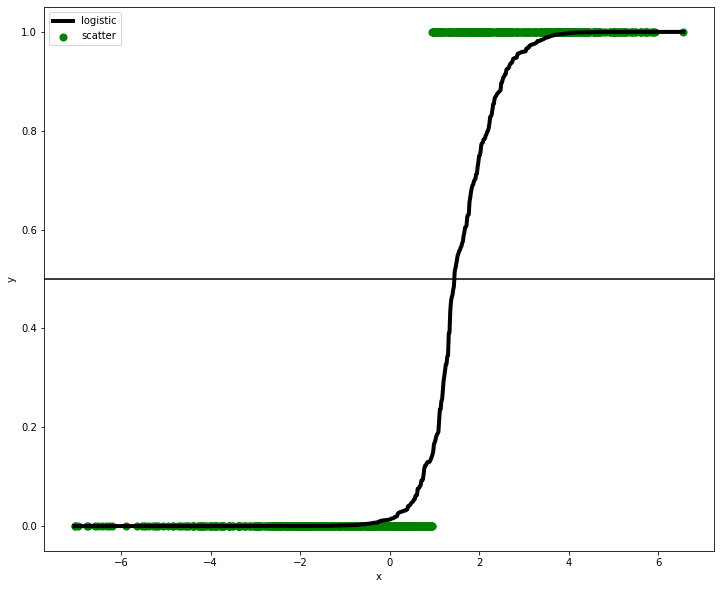

In [140]:
######################################################
#                                                    #
#                       Part F                       #
#                                                    #
######################################################

metrics = []
regul_param = 1
coeffs_list = []
iteration_list = []
alpha_list = [0.1, 0.3, 0.5, 0.7, 0.9, 1]
accumulated_metrics = pd.DataFrame(columns=["alpha", "lambda_param", "accuracy", "precision", "recall", "f1_score", "loss", "iteration" ])

for alpha in alpha_list:
    initial_theta = np.random.rand(X.shape[1]) * 10 + 5 # random values between 5 and 10
    # k-fold cross validation

    ######################################################
    #                                                    #
    #                       Part C                       #
    #                                                    #
    ######################################################

    average_metric_df, coeffs, iteration_mean  = cross_validation(X, y, k_fold_number=5, scoring="f1_score", initial_theta=initial_theta, shuffle=True, alpha=alpha, lambda_param=regul_param, verbose=False)
    accumulated_metrics = accumulated_metrics.append(average_metric_df, ignore_index=True)
    coeffs_list.append(coeffs)
    iteration_list.append(iteration_mean)
accumulated_metrics['iteration'] = iteration_list
accumulated_metrics['coeffs'] = coeffs_list

######################################################
#                                                    #
#                       Part D                       #
#                                                    #
######################################################
alpha_list = accumulated_metrics["alpha"]
iteration_list = accumulated_metrics["iteration"]
plot_iteration_per_alpha(concat_data(alpha_list, iteration_list))

######################################################
#                                                    #
#                       Part E                       #
#                                                    #
######################################################
plot_metrics(accumulated_metrics)


# best alpha and coefficients from accumulated metrics
alpha, regul_param, coeffs, loss, iteration = get_train_fit_min_value(accumulated_metrics, "loss")

# best model coefficients
plot_coeffs(feature_columns, coeffs, alpha, regul_param)

######################################################
#                                                    #
#                   Part A and B                     #
#                                                    #
######################################################
y_predict = predict_logistic_regression(x_test, coeffs) # A
metrics = calculate_metrics(y_test, y_predict) # B
accuracy_value, precision_value, recall_value, f1_score_value, cm_result = metrics
# Confusion Matrix
show_metrics(cm_result)
report_error_df = report_error(y_test, y_predict)
metrics = pd.DataFrame(columns=["value"], index=["alpha", "regul_param", "loss", "iteration", "accuracy", "precision", "recall", "f1_score", "coeffs", "MSE", "MAE", "RMSE", "R2"])
metrics.loc["alpha"] = alpha
metrics.loc["regul_param"] = regul_param
metrics.loc["loss"] = loss
metrics.loc["iteration"] = iteration
metrics.loc["accuracy"] = accuracy_value
metrics.loc["precision"] = precision_value
metrics.loc["recall"] = recall_value
metrics.loc["f1_score"] = f1_score_value
metrics.at["coeffs", "value"] = coeffs
metrics.at["MSE", "value"] = report_error_df["MSE"]
metrics.at["MAE", "value"] = report_error_df["MAE"]
metrics.at["RMSE", "value"] = report_error_df["RMSE"]
metrics.at["R2", "value"] = report_error_df["R squared"]
print(metrics) # B
plot_logistic_regression(x_test.copy(), y_test.copy(), coeffs, column_number=1) 

In [141]:
# # Model Initialization
# metrics = []
# regul_param = 1
# iteration_per_alpha_list = []
# alpha_list = [0.1, 0.3, 0.5, 0.7, 0.9, 1]
# alpha_lambda_coeff_loss_mse_df = pd.DataFrame(columns=["alpha", "lambda", "coeffs", "loss", "mse"])

# for alpha in alpha_list:
#     initial_theta = np.random.rand(X.shape[1]) * 10 + 5 
#     coeffs, theta_history, train_loss_history, validation_loss_history, number_of_iteration = fit_logistic_regression(x_train, y_train, x_validation, y_validation, random_theta , alpha=alpha, regularization_parameter=regul_param, verbose=False)
#     iteration_per_alpha_list.append([alpha, number_of_iteration])

#     plot_loss_train_validation(train_loss_history, validation_loss_history, alpha, regul_param)
#     y_predict_each_alpha = predict_logistic_regression(x_test, coeffs)
#     mean_squared_error = calculate_mse(y_test, y_predict_each_alpha)

#     alpha_lambda_coeff_loss_mse_df = alpha_lambda_coeff_loss_mse_df.append({"alpha": alpha, "lambda": regul_param, "coeffs": coeffs, "loss": validation_loss_history[-1], "mse": mean_squared_error}, ignore_index=True)
#     accuracy_value, precision_value, recall_value, f_beta_score_value = calculate_metrics(y_test, predict_logistic_regression(x_test, coeffs))
#     metrics.append([alpha, accuracy_value, precision_value, recall_value, f_beta_score_value])

# plot_iteration_per_alpha(iteration_per_alpha_list)
# plot_metrics(metrics)

# # print(alpha_lambda_coeff_loss_mse_df)
# alpha, regul_param, coeffs, loss = get_train_fit_min_value(alpha_lambda_coeff_loss_mse_df, "loss")
# print("Best model parameters | alpha:", alpha, ", Coefficients", coeffs, "Loss: ", loss)
# y_predict = predict_logistic_regression(x_test, coeffs)
# metrics = calculate_metrics(y_test, y_predict)
# print("Accuracy: ", metrics[0], "Precision: ", metrics[1], "Recall: ", metrics[2], "F-beta score: ", metrics[3])

# plot_coeffs(feature_columns, coeffs, alpha, regul_param)

# report_error_df = report_error(y_test, y_predict)
# print(report_error_df)

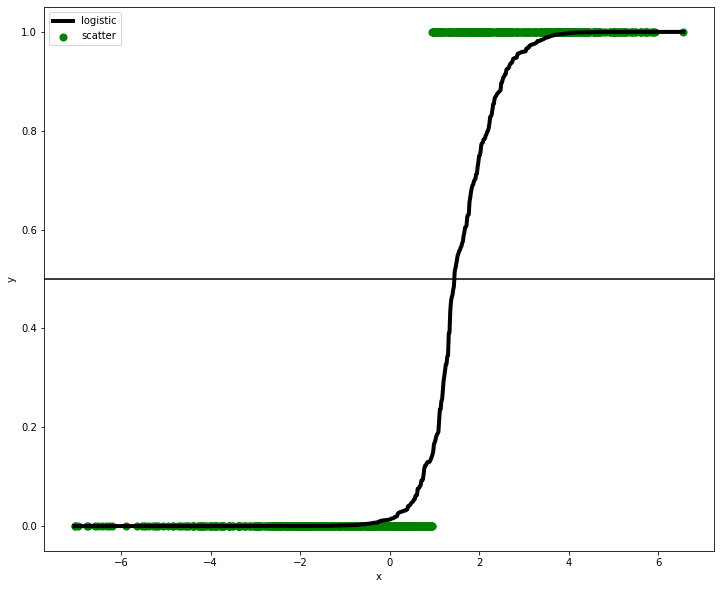

In [146]:
plot_logistic_regression(x_test.copy(), y_test.copy(), coeffs, column_number=1)

In [4]:
# def roc_curve(y_true, y_pred):
#     """
#     ### Calculates the ROC curve and returns the AUC
#     """
#     pass

# Todo:
# implement ROC curve, AUC.

# Explanatory Data Analysis (EDA)

#### Housing distribution on the map


longitude : 1.0 : 0.0
latitude : 1.0 : 0.0
housing_median_age : 1.0 : 0.0
total_rooms : 1.0 : 0.0
total_bedrooms : 1.0 : 0.0
population : 1.0 : 0.0
households : 1.0 : 0.0
median_income : 1.0 : 0.0
population_per_household : inf : 0.0
rooms_per_household : inf : 0.0
ocean_proximity_<1H OCEAN : 1 : 0
ocean_proximity_ISLAND : 1 : 0
ocean_proximity_NEAR BAY : 1 : 0
ocean_proximity_NEAR OCEAN : 1 : 0
median_house_value : 1.0 : 0.029997940004119993


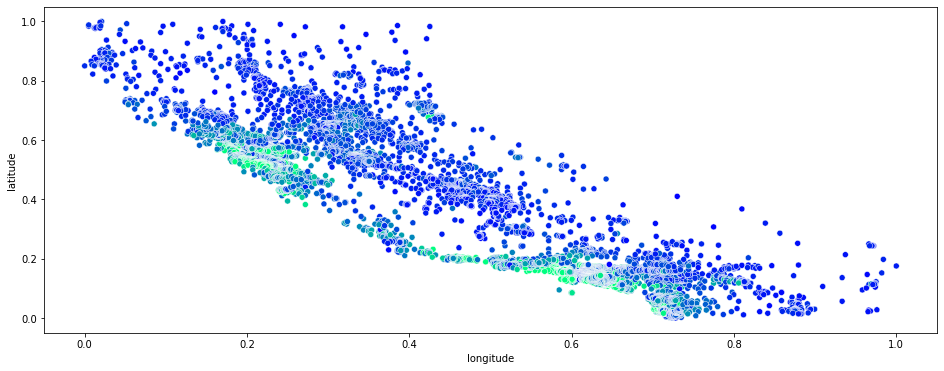

In [ ]:
dataset = load("./housing.csv")

dataset = normalize_missing_values(dataset)

dataset = dataset.assign(median_house_value = dataset["median_house_value"] / dataset["median_house_value"].max())
last_column = dataset["median_house_value"]
dataset = remove_column(dataset, "median_house_value")
dataset = normalize_numerical_columns(dataset)

dataset["population_per_household"] = dataset["population"] / dataset["households"]
dataset["rooms_per_household"] = dataset["total_rooms"] / dataset["households"]

dataset = dummy_encode_categorical_column(dataset, "ocean_proximity")
dataset = remove_column(dataset, "ocean_proximity_INLAND")
dataset = concat_data(dataset, last_column)

# print max and min in each column
for col in dataset.columns:
    print(col, ":", dataset[col].max(), ":", dataset[col].min())

plt.figure(figsize=(16,6))
fig = sns.scatterplot(dataset.longitude, dataset.latitude, hue=dataset['median_house_value'],
                      legend=False, palette='winter')

#### Correlation Matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,population_per_household,rooms_per_household,ocean_proximity_<1H OCEAN,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,median_house_value
longitude,1.0,-0.9,-0.1,0.0,0.1,0.1,0.1,-0.0,0.0,-0.0,0.3,0.0,-0.5,0.0,-0.0
latitude,-0.9,1.0,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,0.0,0.1,-0.4,-0.0,0.4,-0.2,-0.1
housing_median_age,-0.1,0.0,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,0.0,-0.1,0.0,0.0,0.3,0.0,0.1
total_rooms,0.0,-0.0,-0.4,1.0,0.9,0.9,0.9,0.2,-0.0,0.1,-0.0,-0.0,-0.0,-0.0,0.1
total_bedrooms,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0
population,0.1,-0.1,-0.3,0.9,0.9,1.0,0.9,0.0,0.1,-0.1,0.1,-0.0,-0.1,-0.0,-0.0
households,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,0.0,-0.0,-0.1,0.0,-0.0,-0.0,0.0,0.1
median_income,-0.0,-0.1,-0.1,0.2,-0.0,0.0,0.0,1.0,0.0,0.3,0.2,-0.0,0.1,0.0,0.7
population_per_household,0.0,0.0,0.0,-0.0,-0.0,0.1,-0.0,0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
rooms_per_household,-0.0,0.1,-0.1,0.1,-0.0,-0.1,-0.1,0.3,-0.0,1.0,-0.1,0.0,-0.0,-0.0,0.1


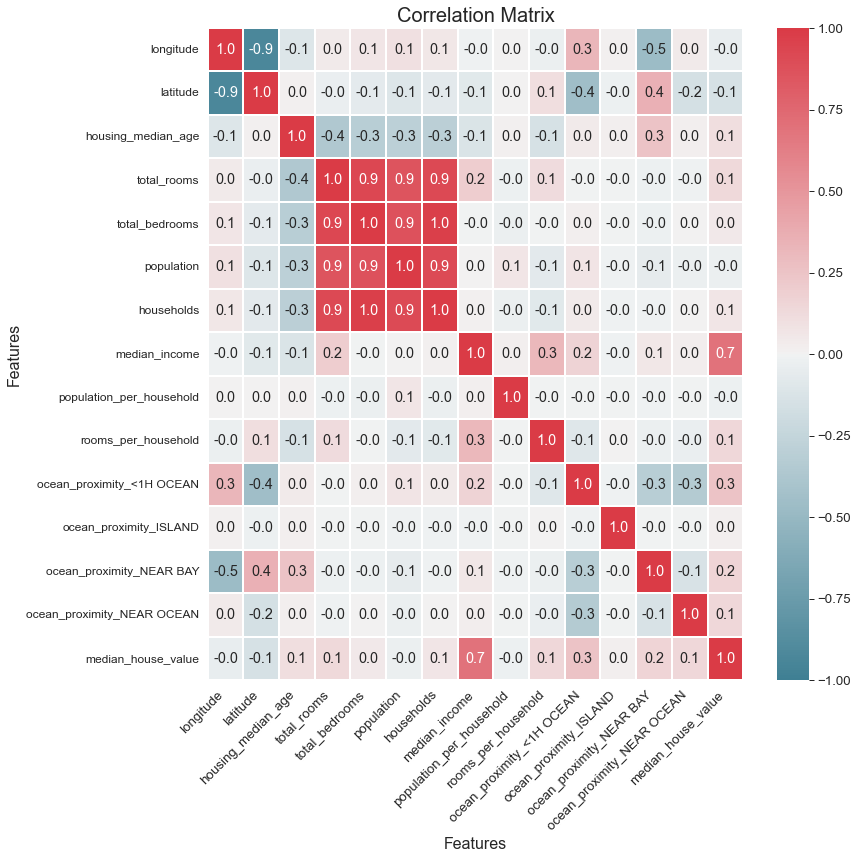

In [ ]:
def correlation_matrix_table(dataset, precision=2):
    correlation_matrix = dataset.corr().style.background_gradient(cmap='coolwarm').set_precision(precision)
    correlation_matrix_render = correlation_matrix.render()
    with open("./correlation_matrix.html", "w") as f:
        f.write(correlation_matrix_render)
    return correlation_matrix

def correlation_matrix_heatmap(dataset, precision=2):
    sns.set(context='paper', style='white', palette='deep', font='sans-serif', font_scale=1.5, color_codes=True)
    fig, ax = plt.subplots(figsize=(12, 12))
    cmap = sns.diverging_palette(220, 10, center='light', as_cmap=True)
    heatmap = sns.heatmap(dataset.corr(), vmax=1, vmin=-1, center=0, square=False, annot=True, cmap=cmap, lw=2, cbar=True, fmt='.{}f'.format(precision))
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
    heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=12)
    heatmap.set_xlabel('Features', fontsize=16)
    heatmap.set_ylabel('Features', fontsize=16)
    heatmap.set_title('Correlation Matrix', fontsize=20)

correlation_matrix_heatmap(dataset, 1)
correlation_matrix_table(dataset, 1)
